In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

# Load Data
MsNPC = spark.read.option("inferSchema", "true").csv("MsNPC.csv", header = True)
MsPlayer = spark.read.option("inferSchema", "true").csv("MsPlayer.csv", header = True)
MsWeapon = spark.read.option("inferSchema", "true").csv("MsWeapon.csv", header = True)
MsWeaponType = spark.read.option("inferSchema", "true").csv("MsWeaponType.csv", header = True)
TransactionDetail = spark.read.option("inferSchema", "true").csv("TransactionDetail.csv", header = True)
TransactionHeader = spark.read.option("inferSchema", "true").csv("TransactionHeader.csv", header = True)

MsNPC.registerTempTable("MsNPC")
MsPlayer.registerTempTable("MsPlayer")
MsWeapon.registerTempTable("MsWeapon")
MsWeaponType.registerTempTable("MsWeaponType")
TransactionDetail.registerTempTable("TransactionDetail")
TransactionHeader.registerTempTable("TransactionHeader")

Visualization

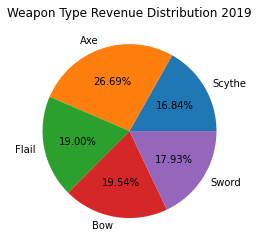

In [ ]:
# a. Show the percentage of weapon type sold for weapon type that is sold in 2019 using pie plot.

soal1 = spark.sql("""
        SELECT WeaponTypeName AS Name, SUM(WeaponPrice * Quantity) AS Revenue
        FROM MsWeaponType mwt 
        JOIN MsWeapon mw ON mwt.WeaponTypeId = mw.WeaponTypeId
        JOIN TransactionDetail td ON td.WeaponId = mw.WeaponId
        JOIN TransactionHeader th ON th.TransactionId = td.TransactionId
        WHERE YEAR(TransactionDate) = 2019
        GROUP BY mwt.WeaponTypeId, mwt.WeaponTypeName
""").toPandas()

plt.pie(soal1["Revenue"], labels = soal1["Name"], autopct="%.2f%%")
plt.title("Weapon Type Revenue Distribution 2019")
plt.show()

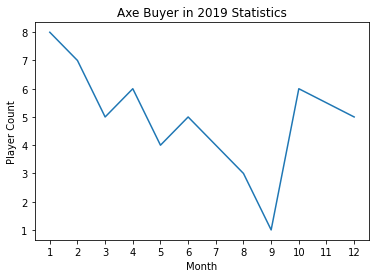

In [ ]:
# b. Show the total number of players who bought axe weapon type per month in 2019 using line plot. Multiple transaction within the same month will be counted as 1.

soal2 = spark.sql("""
        SELECT COUNT(DISTINCT th.PlayerId) AS Count, MONTH(TransactionDate) AS Month
        FROM MsWeaponType mwt 
        JOIN MsWeapon mw ON mwt.WeaponTypeId = mw.WeaponTypeId
        JOIN TransactionDetail td ON td.WeaponId = mw.WeaponId
        JOIN TransactionHeader th ON th.TransactionId = td.TransactionId
        WHERE YEAR(TransactionDate) = 2019 AND mwt.WeaponTypeName = 'Axe'
        GROUP BY Month
        ORDER BY Month
""").toPandas()

plt.plot(soal2["Month"], soal2["Count"])
plt.title("Axe Buyer in 2019 Statistics")
plt.xlabel("Month")
plt.ylabel("Player Count")
plt.xticks(range(1,13))
plt.show()

Clustering

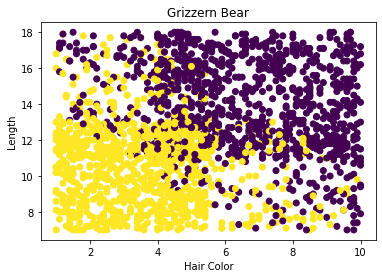

Accuracy = 83.55%


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler, VectorAssembler

# 1. Load Data
train = spark.read.csv("BearTraining.csv", inferSchema=True, header=True)
test = spark.read.csv("BearTesting.csv", inferSchema=True, header=True)

# 2. Select Feature
train = train.select("Pupillary Distance", "Front Claws", "Ear Shape")
test = test.select("Pupillary Distance", "Front Claws", "Ear Shape", "Grizzly")

# 3. Data Preprocessing
train = train.na.drop()
test = test.na.drop()

# 4. Transform Data
train = train.withColumn("Ear Shape", when(train["Ear Shape"] == "Rounded", 0).when(train["Ear Shape"] == "Broad", 1).otherwise(2))

test = test.withColumn("Ear Shape", when(test["Ear Shape"] == "Rounded", 0).when(test["Ear Shape"] == "Broad", 1).otherwise(2))
test = test.withColumn("Grizzly",when(test["Grizzly"] == "Yes", 0).otherwise(1))

# 5. Normalization
columns = train.columns
columns = test.columns
columns.remove("Grizzly")

train = VectorAssembler(inputCols=columns, outputCol="FeatureVector").transform(train)
test = VectorAssembler(inputCols=columns, outputCol="FeatureVector").transform(test)

train = StandardScaler(inputCol="FeatureVector", outputCol="Feature").fit(train).transform(train)
test = StandardScaler(inputCol="FeatureVector", outputCol="Feature").fit(test).transform(test)

# 6. Generate Model
kmeans = KMeans(featuresCol="Feature",k=2, seed=1)
model = kmeans.fit(train)
predict = model.transform(test)
pandas = predict.toPandas()

# 7. Visualization 
plt.scatter(pandas["Front Claws"],pandas["Pupillary Distance"], c= pandas["prediction"])
plt.title("Grizzern Bear")
plt.xlabel("Hair Color")
plt.ylabel("Length")
plt.show()

# 8. Model Testing and Evaluation
counter = 0
for index, row in pandas.iterrows():
  if row["Grizzly"] == row["prediction"]:
    counter +=1
print(f"Accuracy = {((counter/predict.count()) * 100)}%")